# Library setup
This part installs libraries and prepares the environment for the workflow. It creates a clean base to run the rest of the notebook. It ensures every tool loads without issues and stays consistent across runs.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


sns.set_style('whitegrid')


# Dataset loading

In [2]:
real = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

real['label'] = 'real'
fake['label'] = 'fake'

data = pd.concat([real, fake], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


# EDA
This part inspects the structure of the dataset. It looks at missing values, duplicated rows, basic statistics, and the shape. It helps understand how the data behaves and what problems appear early. It guides later cleaning steps.

In [3]:
data.head(10)

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",fake
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",fake
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",fake
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",real
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",fake
5,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",real
6,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",real
7,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",real
8,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",fake
9,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",fake


In [4]:
data.tail(10)

,title,text,subject,date,label
44888,Mueller Team Uniform? ‘Democratic Donkey Jerse...,Deputy Attorney General Rod Rosenstein appeare...,Middle-east,"December 13, 2017",fake
44889,Watch This Nazi Cry Like A Little B*tch After...,"Christopher Cantwell, one of the Nazis feature...",News,"August 16, 2017",fake
44890,(VIDEO)REP ELIJAH CUMMINGS AND OTHERS DOWNPLAY...,OOPS! The narrative isn t fitting the truth an...,politics,"Apr 26, 2015",fake
44891,Fighting in southern Philippine city may end i...,"MARAWI CITY, Philippines (Reuters) - The Phili...",worldnews,"October 21, 2017",real
44892,New York protesters camp out at Goldman Sachs ...,NEW YORK (Reuters) - Dozens of protesters gath...,politicsNews,"January 18, 2017",real
44893,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,worldnews,"December 27, 2017",real
44894,Boiler Room #62 – Fatal Illusions,Tune in to the Alternate Current Radio Network...,Middle-east,"June 29, 2016",fake
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,I m convinced the Freedom From Religion group...,Government News,"Feb 27, 2016",fake
44896,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",real
44897,U.N. refugee commissioner says Australia must ...,SYDNEY (Reuters) - The U.N. High Commissioner ...,worldnews,"November 1, 2017",real


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [6]:
print('Duplicate titles:', data.duplicated(subset=['title']).sum())
print('Duplicate texts:', data.duplicated(subset=['text']).sum())


Duplicate titles: 6169
Duplicate texts: 6252


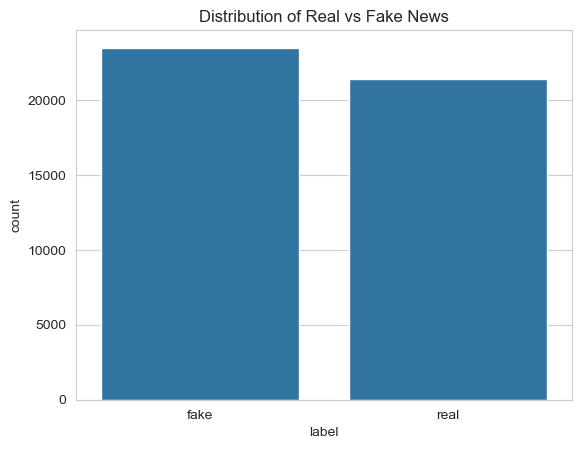

In [7]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Real vs Fake News')
plt.show()


In [8]:
data['text_len'] = data['text'].apply(lambda x: len(str(x).split()))
data['title_len'] = data['title'].apply(lambda x: len(str(x).split()))


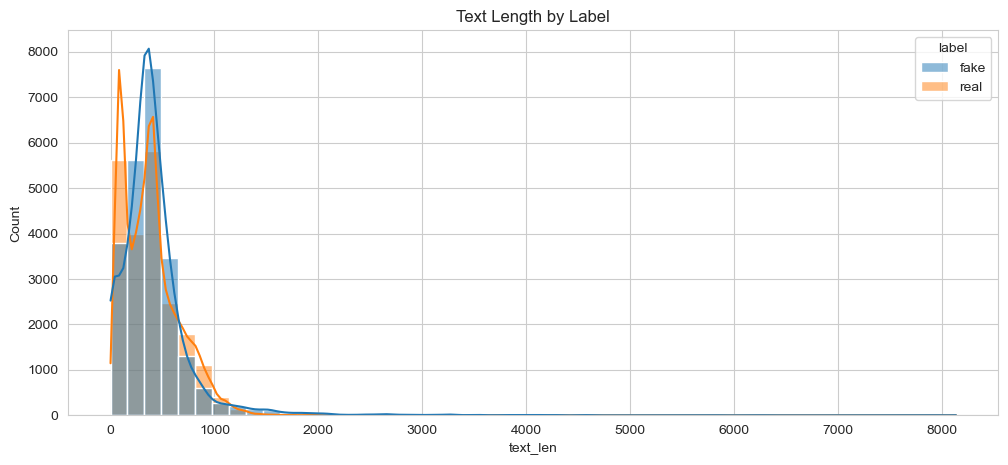

In [9]:
plt.figure(figsize=(12,5))
sns.histplot(data=data, x='text_len', hue='label', bins=50, kde=True)
plt.title('Text Length by Label')
plt.show()


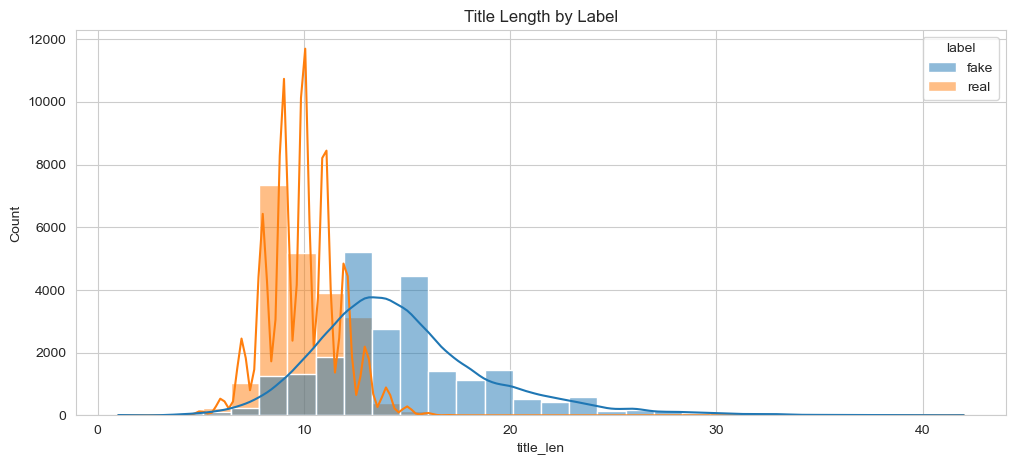

In [10]:
plt.figure(figsize=(12,5))
sns.histplot(data=data, x='title_len', hue='label', bins=30, kde=True)
plt.title('Title Length by Label')
plt.show()


# Word and n-gram analysis
This part identifies the most frequent words and bigrams in real and fake news to understand patterns in text.

In [11]:
def get_top_words(text_series, n=20):
    words = Counter()
    for text in text_series.dropna():
        words.update(re.findall(r"\w+", str(text).lower()))
    return words.most_common(n)
    
print('Top words in real news:', get_top_words(data[data['label']=='real']['text'], 15))
print('Top words in fake news:', get_top_words(data[data['label']=='fake']['text'], 15))


Top words in real news: [('the', 482468), ('to', 245734), ('of', 205275), ('a', 198580), ('and', 182081), ('in', 181652), ('s', 141421), ('on', 108594), ('said', 99062), ('that', 88237), ('for', 79895), ('is', 55494), ('trump', 54700), ('with', 54504), ('he', 54370)]
Top words in fake news: [('the', 543551), ('to', 290819), ('of', 236640), ('and', 226971), ('a', 214783), ('in', 171163), ('that', 151662), ('s', 141155), ('is', 111234), ('for', 93480), ('on', 83591), ('it', 83380), ('trump', 79300), ('he', 78997), ('was', 67857)]


In [12]:
def top_ngrams(text_series, n=10, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(text_series.dropna())
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:n]

print("Top bigrams in real news:", top_ngrams(data[data['label']=='real']['text']))
print("Top bigrams in fake news:", top_ngrams(data[data['label']=='fake']['text']))

Top bigrams in real news: [('united states', 12204), ('donald trump', 10168), ('white house', 8419), ('washington reuters', 6674), ('president donald', 5930), ('north korea', 5659), ('new york', 4740), ('prime minister', 4163), ('said statement', 3933), ('trump said', 3551)]
Top bigrams in fake news: [('donald trump', 16288), ('featured image', 7692), ('hillary clinton', 7278), ('white house', 6743), ('united states', 6663), ('twitter com', 6567), ('pic twitter', 6195), ('new york', 4352), ('president obama', 4081), ('getty images', 4022)]


# Time-based analysis
This part converts dates and extracts temporal trends. It checks monthly or yearly patterns. It shows how text production changes with time. It helps understand cycles or peaks.

In [13]:
#prepare dates
data_with_date = data.copy()
data_with_date['date'] = pd.to_datetime(data_with_date['date'], errors='coerce')
data_with_date = data_with_date.dropna(subset=['date'])


In [14]:
monthly_counts = pd.DataFrame()

for label in data_with_date['label'].unique():
    temp = (
        data_with_date[data_with_date['label'] == label]
        .set_index('date')
        .resample('ME')
        .size()
        .rename(label)
    )
    monthly_counts = pd.concat([monthly_counts, temp], axis=1)


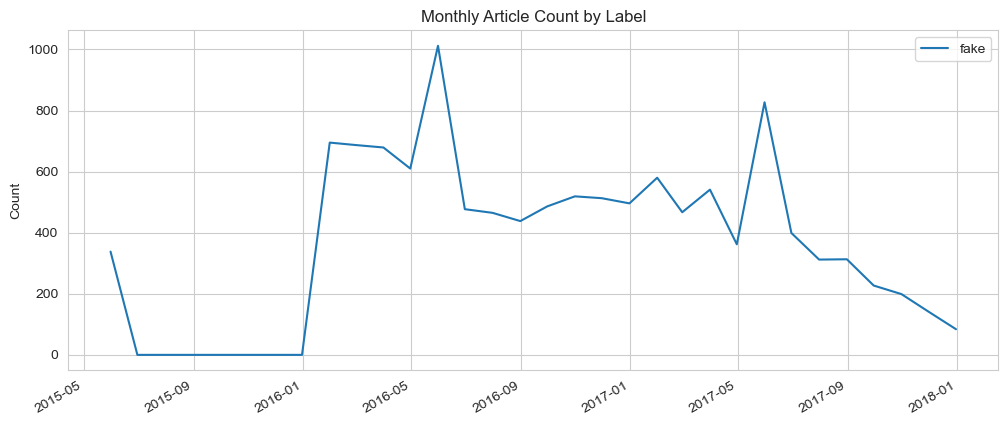

In [15]:
monthly_counts.plot(kind='line', figsize=(12,5))
plt.title('Monthly Article Count by Label')
plt.ylabel('Count')
plt.show()


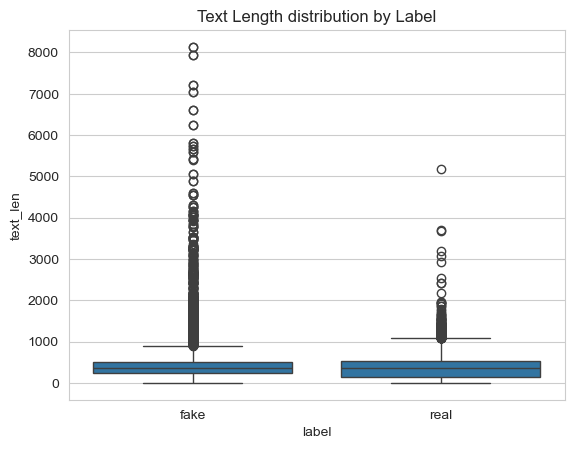

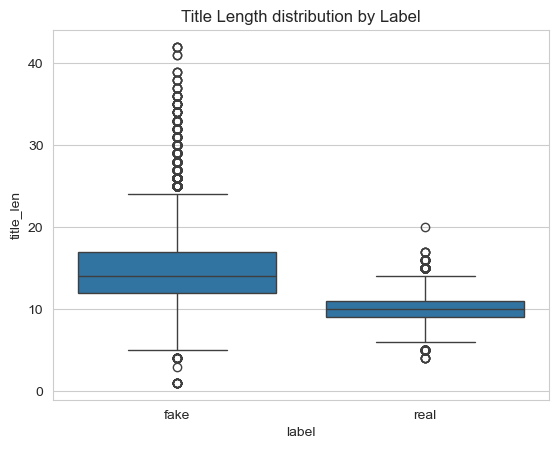

In [16]:
sns.boxplot(x='label', y='text_len', data=data)
plt.title('Text Length distribution by Label')
plt.show()

sns.boxplot(x='label', y='title_len', data=data)
plt.title('Title Length distribution by Label')
plt.show()


In [17]:
data['num_links'] = data['text'].apply(lambda x: len(re.findall(r'http[s]?://', str(x))))
data['num_numbers'] = data['text'].apply(lambda x: len(re.findall(r'\d+', str(x))))
data['num_special_chars'] = data['text'].apply(lambda x: len(re.findall(r'[^\w\s]', str(x))))


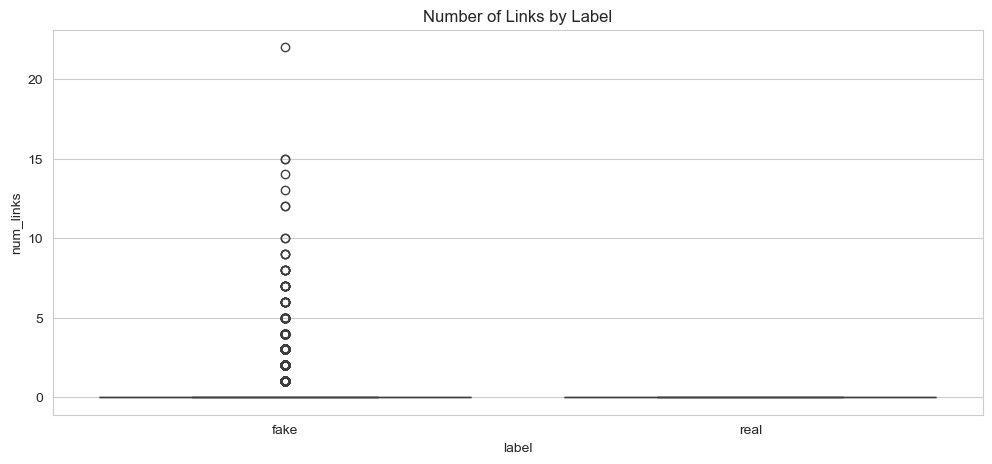

In [18]:
plt.figure(figsize=(12,5))
sns.boxplot(x='label', y='num_links', data=data)
plt.title('Number of Links by Label')
plt.show()


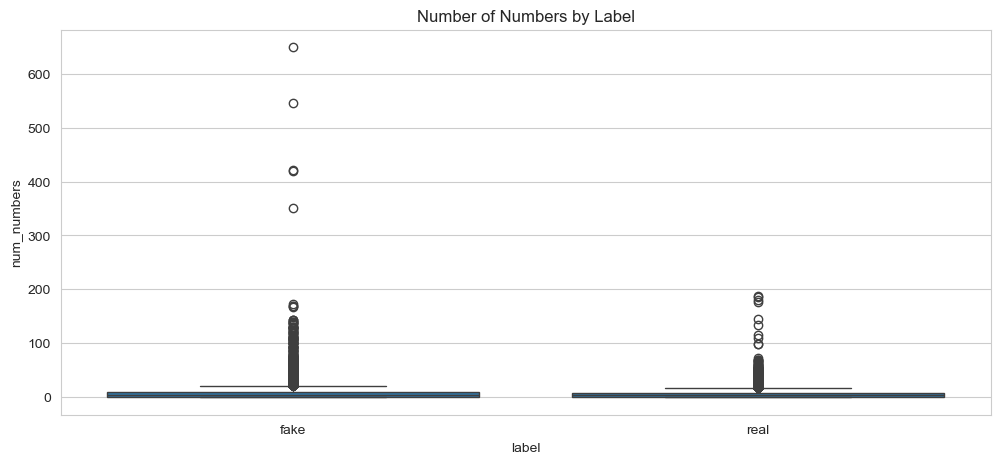

In [19]:
plt.figure(figsize=(12,5))
sns.boxplot(x='label', y='num_numbers', data=data)
plt.title('Number of Numbers by Label')
plt.show()


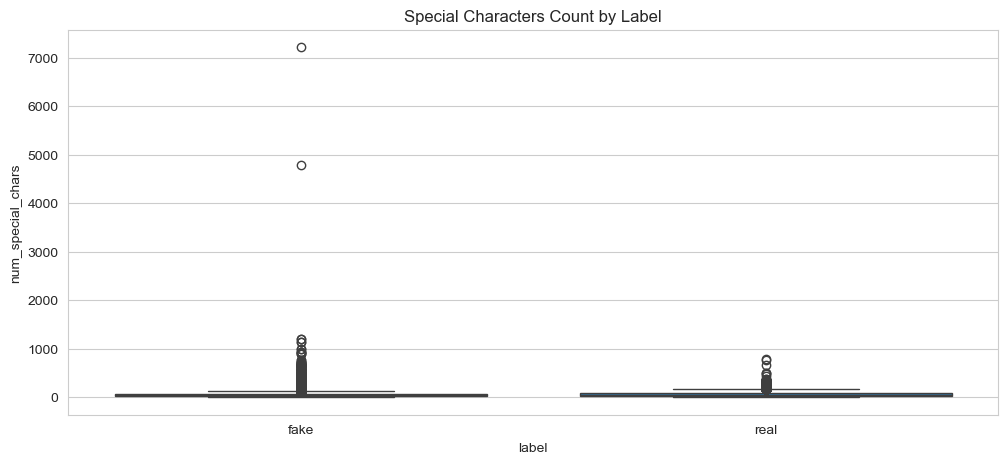

In [20]:
plt.figure(figsize=(12,5))
sns.boxplot(x='label', y='num_special_chars', data=data)
plt.title('Special Characters Count by Label')
plt.show()


In [21]:


'''
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

'''

"\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('stopwords')\n\n"

In [22]:
# in this next part we are just learning about stemming & lemmatization

In [23]:
sample_texts = data['text'].dropna().head(3).tolist()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


In [24]:
def stem_text(text):
    tokens = word_tokenize(text)
    stems = [stemmer.stem(token) for token in tokens]
    return ' '.join(stems)


In [25]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmas)


In [26]:
for i, text in enumerate(sample_texts):
    print("\nOriginal")
    print(text[:150])
    print("\nStemmed")
    print(stem_text(text)[:150])
    print("\nLemmatized")
    print(lemmatize_text(text)[:150])



Original
Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowl

Stemmed
donald trump s white hous is in chao , and they are tri to cover it up . their russia problem are mount by the hour , and they refus to acknowledg tha

Lemmatized
Donald Trump s White House is in chaos , and they are trying to cover it up . Their Russia problem are mounting by the hour , and they refuse to ackno

Original
Now that Donald Trump is the presumptive GOP nominee, it s time to remember all those other candidates who tried so hard to beat him in the race to th

Stemmed
now that donald trump is the presumpt gop nomine , it s time to rememb all those other candid who tri so hard to beat him in the race to the white hou

Lemmatized
Now that Donald Trump is the presumptive GOP nominee , it s time to remember all those other candidate who tried so hard to beat him in the race to th

Original
Mike Pence is a huge h

# Vocabulary and frequency analysis
This part inspects the vocabulary size. It counts unique words and checks how often each appears. It helps understand dataset richness. It guides decisions on model size and filtering.

In [27]:
all_words = []
for text in data['text'].dropna():
    all_words.extend(word_tokenize(text.lower()))

word_freq = Counter(all_words)
print(word_freq.most_common(20))


[('the', 1010865), (',', 889959), ('.', 596502), ('to', 534790), ('of', 440765), ('a', 408923), ('and', 406230), ('in', 345530), ('that', 238378), ('s', 229543), ('on', 189700), ('for', 171845), ('is', 166326), ('he', 131995), ('said', 130186), ('it', 128738), ('trump', 128490), ('with', 117449), ('was', 115734), ('as', 103285)]


In [28]:
vocab = set()
for text in data['text'].dropna():
    vocab.update(word_tokenize(text.lower()))

print("Vocabulary size:", len(vocab))


Vocabulary size: 225737


<Axes: xlabel='Samples', ylabel='Counts'>

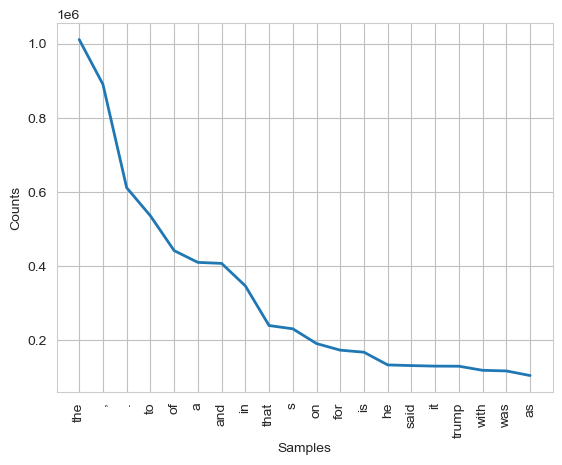

In [29]:
all_tokens = [w.lower() for text in data['text'].dropna() for w in word_tokenize(text)]
freq_dist = FreqDist(all_tokens)
freq_dist.plot(20)


In [30]:
print("Number of duplicate texts:", data['text'].duplicated().sum())


Number of duplicate texts: 6252


# Text preprocessing
This part cleans text. It removes noise, fixes spacing, lowers case, and clears special characters. It prepares text for tokenization and modeling. It ensures consistency across samples.

In [31]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    stop_words = set(stopwords.words("english"))
    tokens = [t for t in tokens if t not in stop_words]

    tokens = [t for t in tokens if len(t) > 3]

    unique_idx = np.unique(tokens, return_index=True)[1]
    cleaned = np.array(tokens)[np.sort(unique_idx)].tolist()

    return cleaned


In [32]:
x = data.drop('label', axis=1)
y = data.label

texts = list(x['text'])


In [33]:
cleaned_text = [process_text(text) for text in texts]
print(cleaned_text[:10])


[['donald', 'trump', 'white', 'house', 'chaos', 'trying', 'cover', 'russia', 'problem', 'mounting', 'hour', 'refuse', 'acknowledge', 'surrounding', 'fake', 'news', 'hoax', 'however', 'fact', 'bear', 'thing', 'differently', 'seems', 'crack', 'congressional', 'public', 'leadership', 'chuck', 'grassley', 'iowa', 'head', 'senate', 'judiciary', 'committee', 'demanding', 'former', 'campaign', 'manager', 'paul', 'manafort', 'testify', 'regarding', 'infamous', 'shady', 'meeting', 'russian', 'lawyer', 'promised', 'dirt', 'democratic', 'presidential', 'nominee', 'hillary', 'clinton', 'information', 'well', 'demand', 'sends', 'signal', 'team', 'notably', 'fire', 'special', 'counsel', 'robert', 'mueller', 'circumstance', 'despite', 'laying', 'groundwork', 'speak', 'tweet', 'warning', 'also', 'anyone', 'think', 'senator', 'rest', 'serious', 'need', 'look', 'already', 'given', 'either', 'follow', 'order', 'served', 'subpoena', 'force', 'comply', 'held', 'contempt', 'congress', 'carry', 'jail', 'time

# Model training and evaluation
This part trains classification models. It splits data, builds the model, fits it, and evaluates accuracy and loss. It gives a first measure of performance. It exposes strengths and weaknesses.

In [34]:
data['combined_text'] = data['title'] + " " + data['text']

X = data['combined_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=23,
    stratify=y
)

# Build Pipelines With Models
models = {
    'Logistic Regression': LogisticRegression(
        solver='saga',
        max_iter=1000,
        random_state=23
    ),

    'SVM': LinearSVC(random_state=23)    # support verctor machine
}

result = {}

for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', TfidfVectorizer(
            ngram_range=(1, 2),
            max_df=0.8,
            min_df=5
        )),
        ('regressor', regressor)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    result[name] = accuracy

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report\n{classification_report(y_test, y_pred)}\n')

Model: Logistic Regression
Accuracy: 0.988641425389755
Classification Report
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4696
        real       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Model: SVM
Accuracy: 0.9965478841870824
Classification Report
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4696
        real       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980




# Model comparison
This part compares all trained models. It uses accuracy scores, precision, recall, and confusion matrices. It identifies the most reliable model. It supports the final choice.

The best model is SVM, with an accuracy of 0.9965478841870824


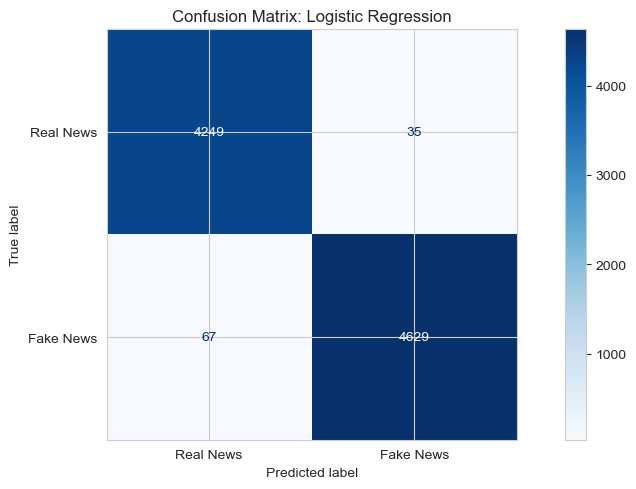

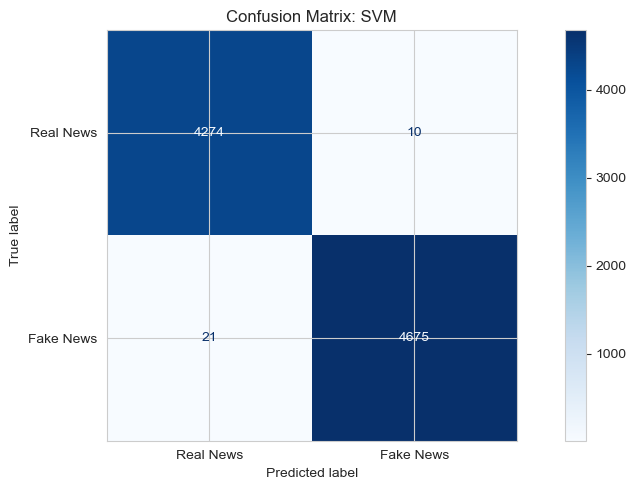

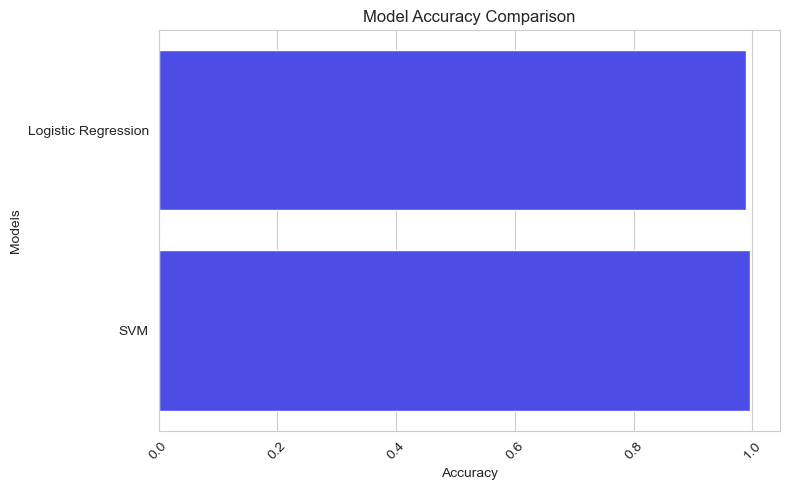

In [35]:
best_model = max(result, key=result.get)
best_accuracy = result[best_model]

print(f'The best model is {best_model}, with an accuracy of {best_accuracy}')

# Confusion Matrices
for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', TfidfVectorizer(
            ngram_range=(1, 2),
            max_df=0.8,
            min_df=5
        )),
        ('regressor', regressor)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    fig, ax = plt.subplots(figsize=(10, 5))
    cm = confusion_matrix(y_test, y_pred, labels=['real', 'fake'])

    ConfusionMatrixDisplay(
        cm,
        display_labels=['Real News', 'Fake News']
    ).plot(cmap='Blues', ax=ax)

    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()


# Model Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(
    x=list(result.values()),
    y=list(result.keys()),
    color='#33f'
)
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()

# Prediction on new texts
This part tests the model on unseen text. It checks how the model reacts to real inputs. It validates practical usefulness. It closes the workflow with practical results.

In [36]:
sample_reviews = [
    'Authorities in Nigeria are increasing efforts to tackle investment scams, especially those involving crypto platforms.',
    'NASA secretly admitted that the Moon landing was faked and astronauts never left Earth.',
    'The government successfully passed a new education reform bill today, aiming to improve access to schools and increase funding for teachers. Lawmakers and citizens praised the initiative as a major step forward for the country’s future.'
]

best_model = Pipeline([
    ('preprocessor', TfidfVectorizer()),
    ('regressor', LinearSVC(random_state=23))
])

best_model.fit(X_train, y_train)
preds = best_model.predict(sample_reviews)

for i, (review, pred) in enumerate(zip(sample_reviews, preds)):
    print(f'\n{i}. Review: {review}\nPredicted Score: {pred}')



0. Review: Authorities in Nigeria are increasing efforts to tackle investment scams, especially those involving crypto platforms.
Predicted Score: fake

1. Review: NASA secretly admitted that the Moon landing was faked and astronauts never left Earth.
Predicted Score: fake

2. Review: The government successfully passed a new education reform bill today, aiming to improve access to schools and increase funding for teachers. Lawmakers and citizens praised the initiative as a major step forward for the country’s future.
Predicted Score: fake
